https://pseudo-lab.github.io/Tutorial-Book-en/chapters/en/time-series/Ch5-CNN-LSTM.html

In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim



In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
strFileName = "/Users/gauchetvanantwerpen/Documents/01 gvaLokaalDocs/01 Pers/02 Nisse/02 development/02 nissedb/results/SOL.JO.csv"

df = pd.read_csv(strFileName, usecols=[0,4],  index_col=0,engine='python')


In [ ]:
"""!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip"""

In [ ]:
# Load the cumulative COVID-19 cases for South Korea.
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')

In [5]:
df.index = pd.to_datetime(df.index)

In [12]:
df_diff = df.diff().fillna(0)

<AxesSubplot:xlabel='Date'>

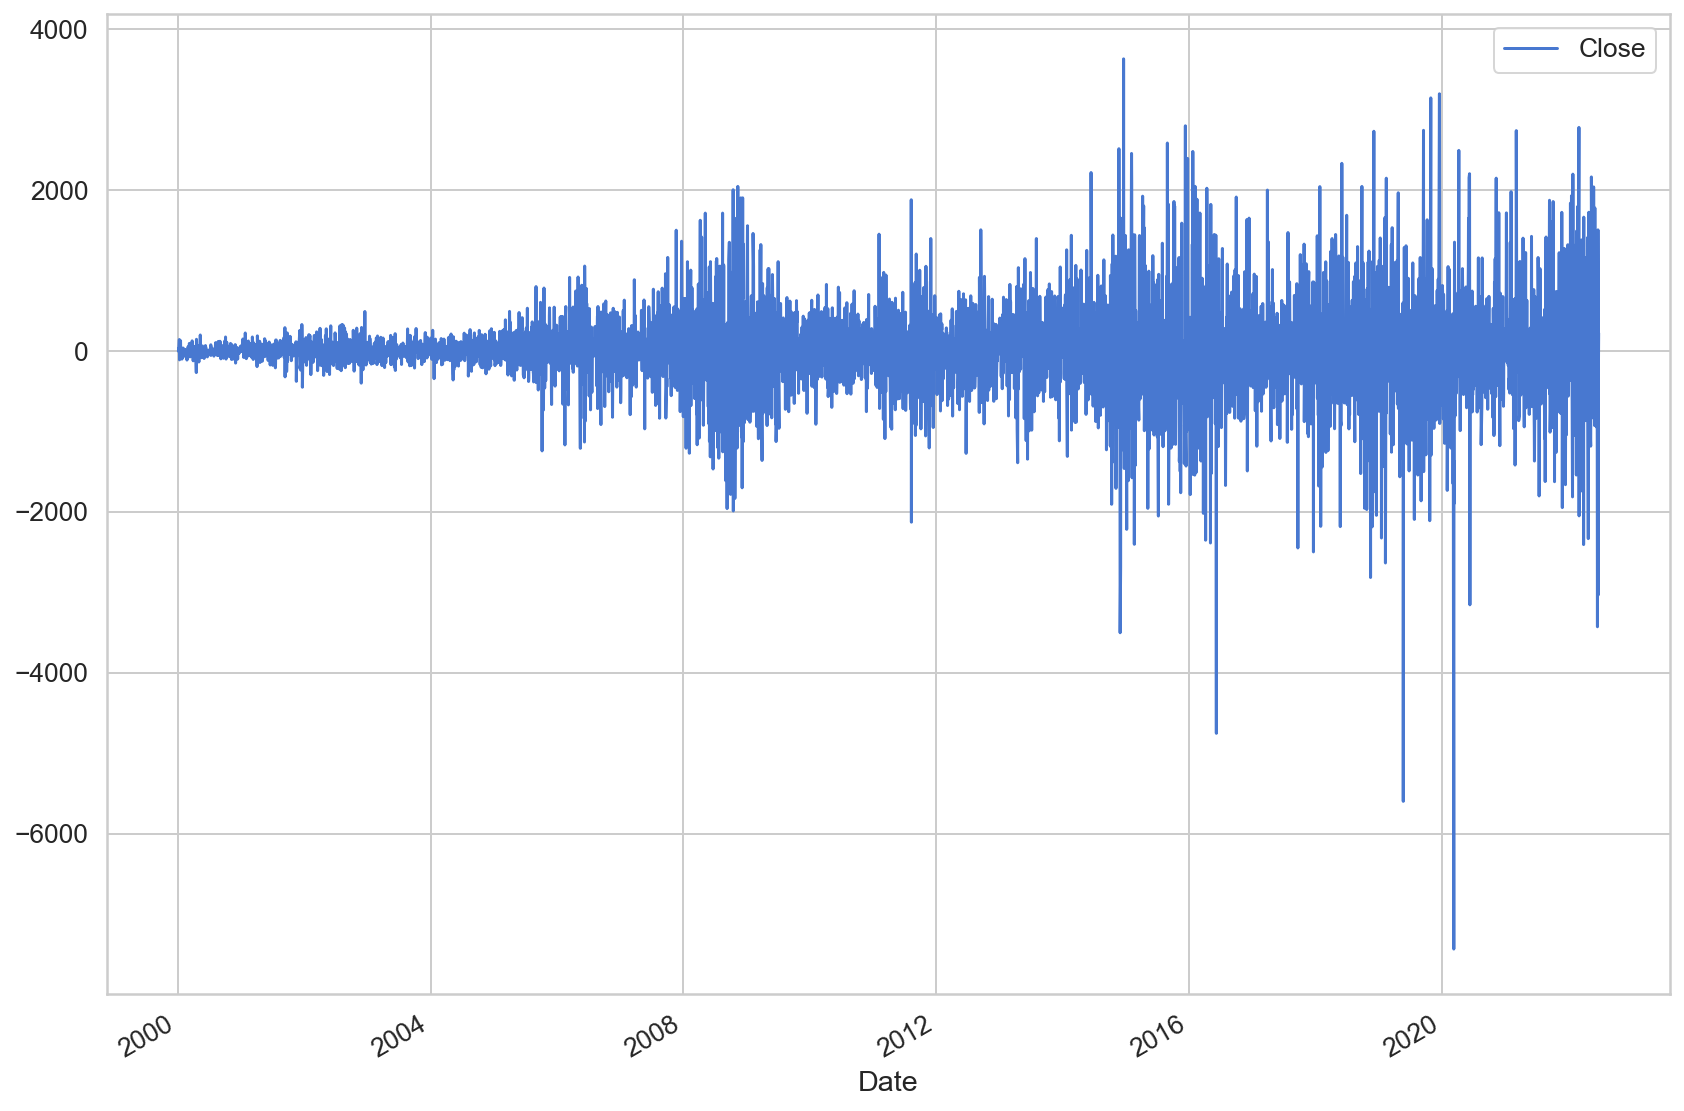

In [13]:
df_diff.plot()

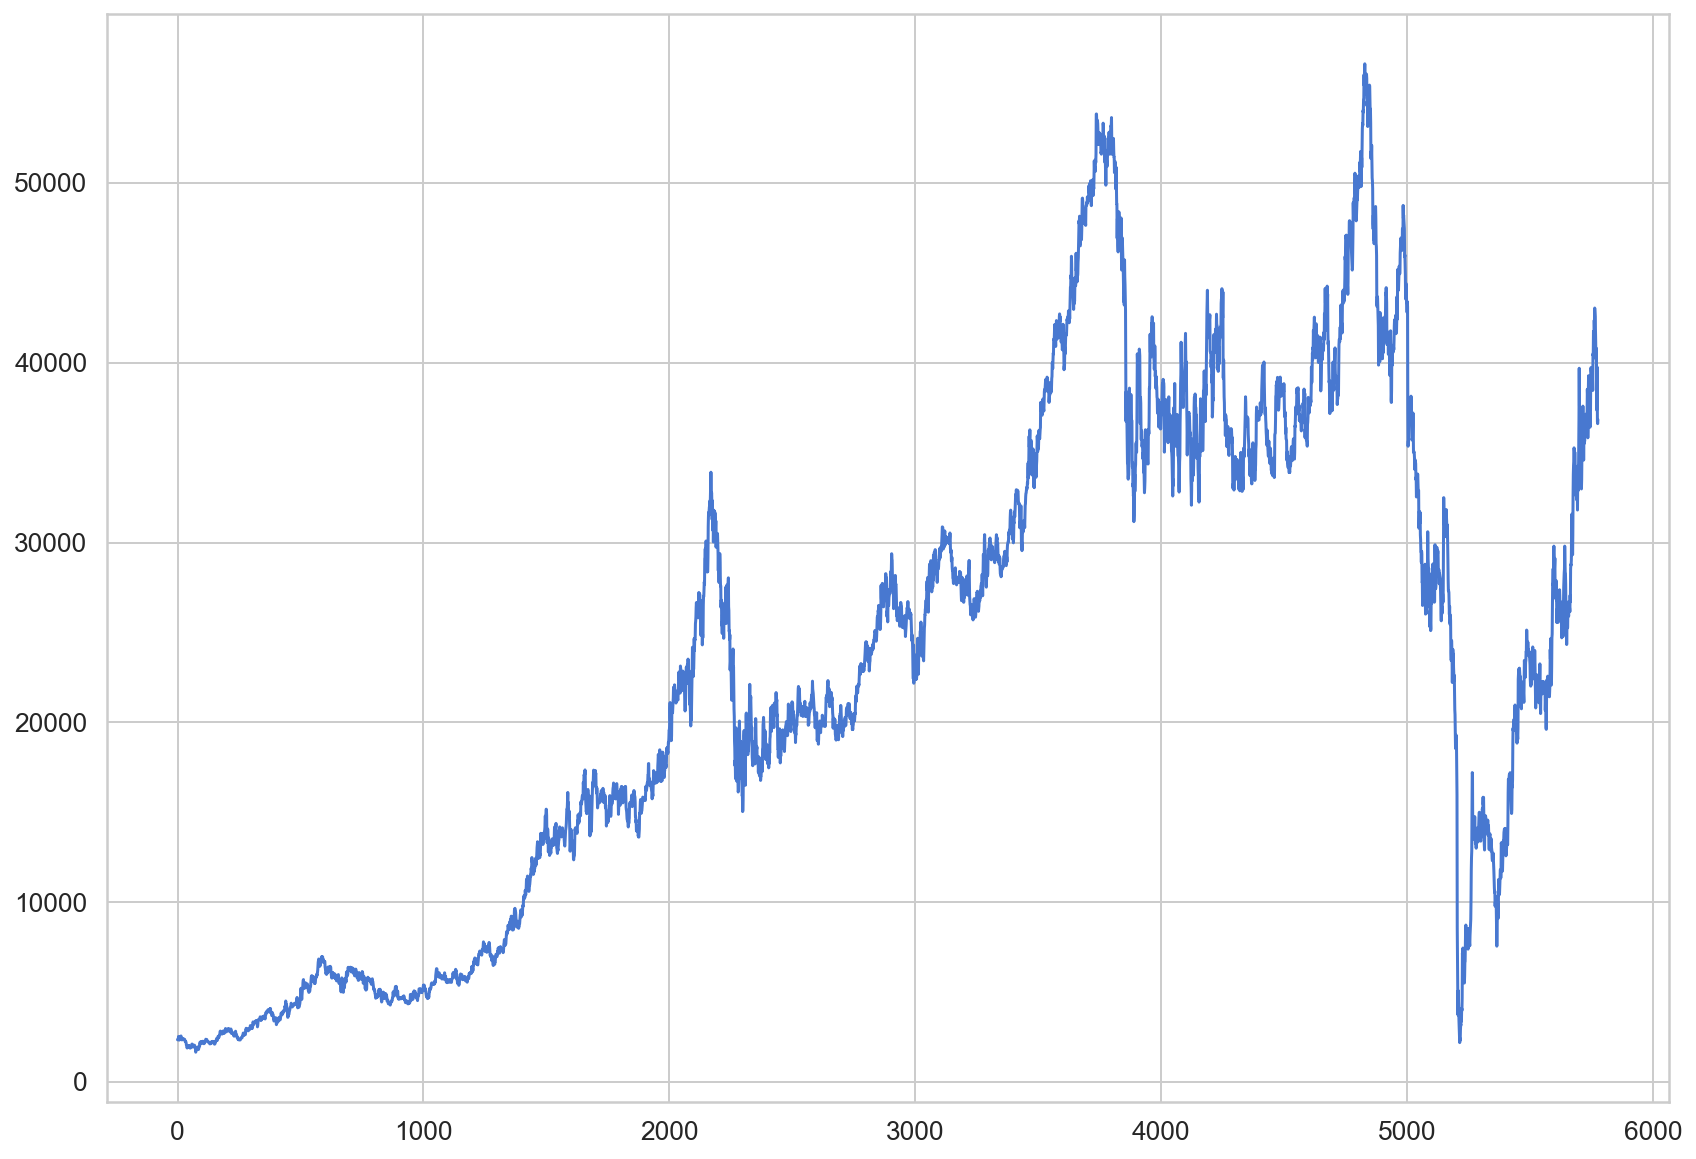

In [14]:
plt.plot(df.values)

In [15]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Data transformation for supervised learning data.
seq_length = 5
X, y = create_sequences(df_diff, seq_length)
#X, y = create_sequences(daily_cases, seq_length)

In [18]:
# Dividing the dataset into traning, validation, and test sets.
#train_size = int(327 * 0.8)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

In [19]:
X_train

array([[[   0.        ],
        [  -2.38598633],
        [  35.78833008],
        [   9.54272461],
        [ 143.15185547]],

       [[  -2.38598633],
        [  35.78833008],
        [   9.54272461],
        [ 143.15185547],
        [-109.7487793 ]],

       [[  35.78833008],
        [   9.54272461],
        [ 143.15185547],
        [-109.7487793 ],
        [ -33.40307617]],

       ...,

       [[ 795.53125   ],
        [ 800.33984375],
        [-384.31640625],
        [ 680.23828125],
        [-127.78515625]],

       [[ 800.33984375],
        [-384.31640625],
        [ 680.23828125],
        [-127.78515625],
        [1085.69140625]],

       [[-384.31640625],
        [ 680.23828125],
        [-127.78515625],
        [1085.69140625],
        [-404.48828125]]])

In [20]:

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

# MinMax scaling
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

# Tensor transformation
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

## Modelling

In [21]:
c = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
input = torch.Tensor([[[1,2,3,4,5]]])
output = c(input)
output

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<SqueezeBackward1>)

In [22]:
for param in c.parameters():
    print(param)

Parameter containing:
tensor([[[0.5406, 0.5869]]], requires_grad=True)
Parameter containing:
tensor([-0.1657], requires_grad=True)


In [23]:
w_list = []
for param in c.parameters():
    w_list.append(param)

w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1)
print(w2)
print(b)

tensor(0.5406, grad_fn=<SelectBackward0>)
tensor(0.5869, grad_fn=<SelectBackward0>)
Parameter containing:
tensor([-0.1657], requires_grad=True)


In [24]:
w1 * 3 + w2 * 4 + b

tensor([3.8038], grad_fn=<AddBackward0>)

In [25]:
output

tensor([[[1.5488, 2.6763, 3.8038, 4.9313]]], grad_fn=<SqueezeBackward1>)

In [26]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # Add a 1D CNN layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [27]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # hidden state needs to be reset after every sample

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # calculated loss after 1 step

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # hidden state reset every sequence

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # append in val hist

            ## print loss for every `verbose` times
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## check early stopping for every `patience` times
            if (t % patience == 0) & (t != 0):
                
                ## if loss increased, perform early stopping
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [28]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

In [29]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


#### Trainning

In [30]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.05305354709307146 val loss: 0.0658511072397232
Epoch 10 train loss: 0.03647826997676607 val loss: 0.062295813113451004
Epoch 20 train loss: 0.03631847583682139 val loss: 0.06198546290397644
Epoch 30 train loss: 0.03630359215552553 val loss: 0.061973340809345245
Epoch 40 train loss: 0.03628541807062522 val loss: 0.061994776129722595
Epoch 50 train loss: 0.0362570838789313 val loss: 0.06209557130932808
Epoch 60 train loss: 0.036227837027423125 val loss: 0.06211566925048828
Epoch 70 train loss: 0.036179362313944155 val loss: 0.06216072291135788
Epoch 80 train loss: 0.03613751853651006 val loss: 0.06198880076408386
Epoch 90 train loss: 0.036105624422873156 val loss: 0.06194893643260002


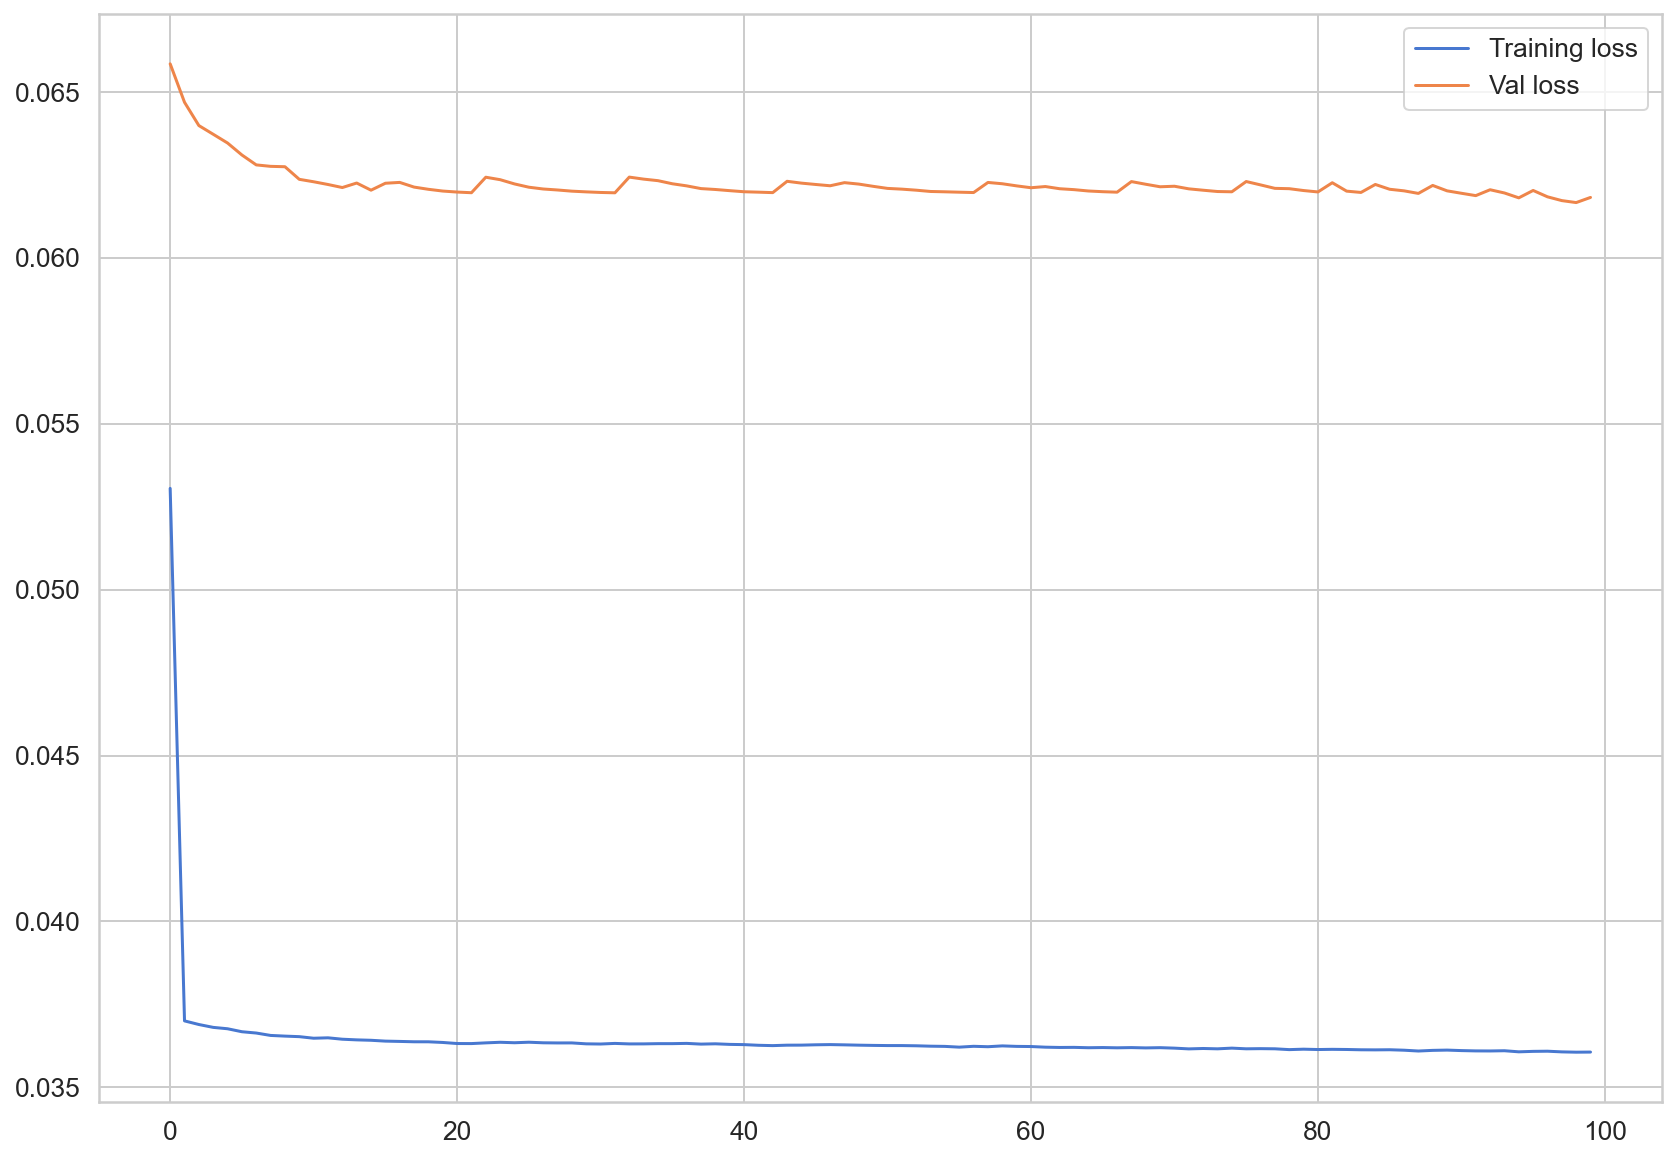

In [31]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

#### Predict Confirmed Cases

In [32]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

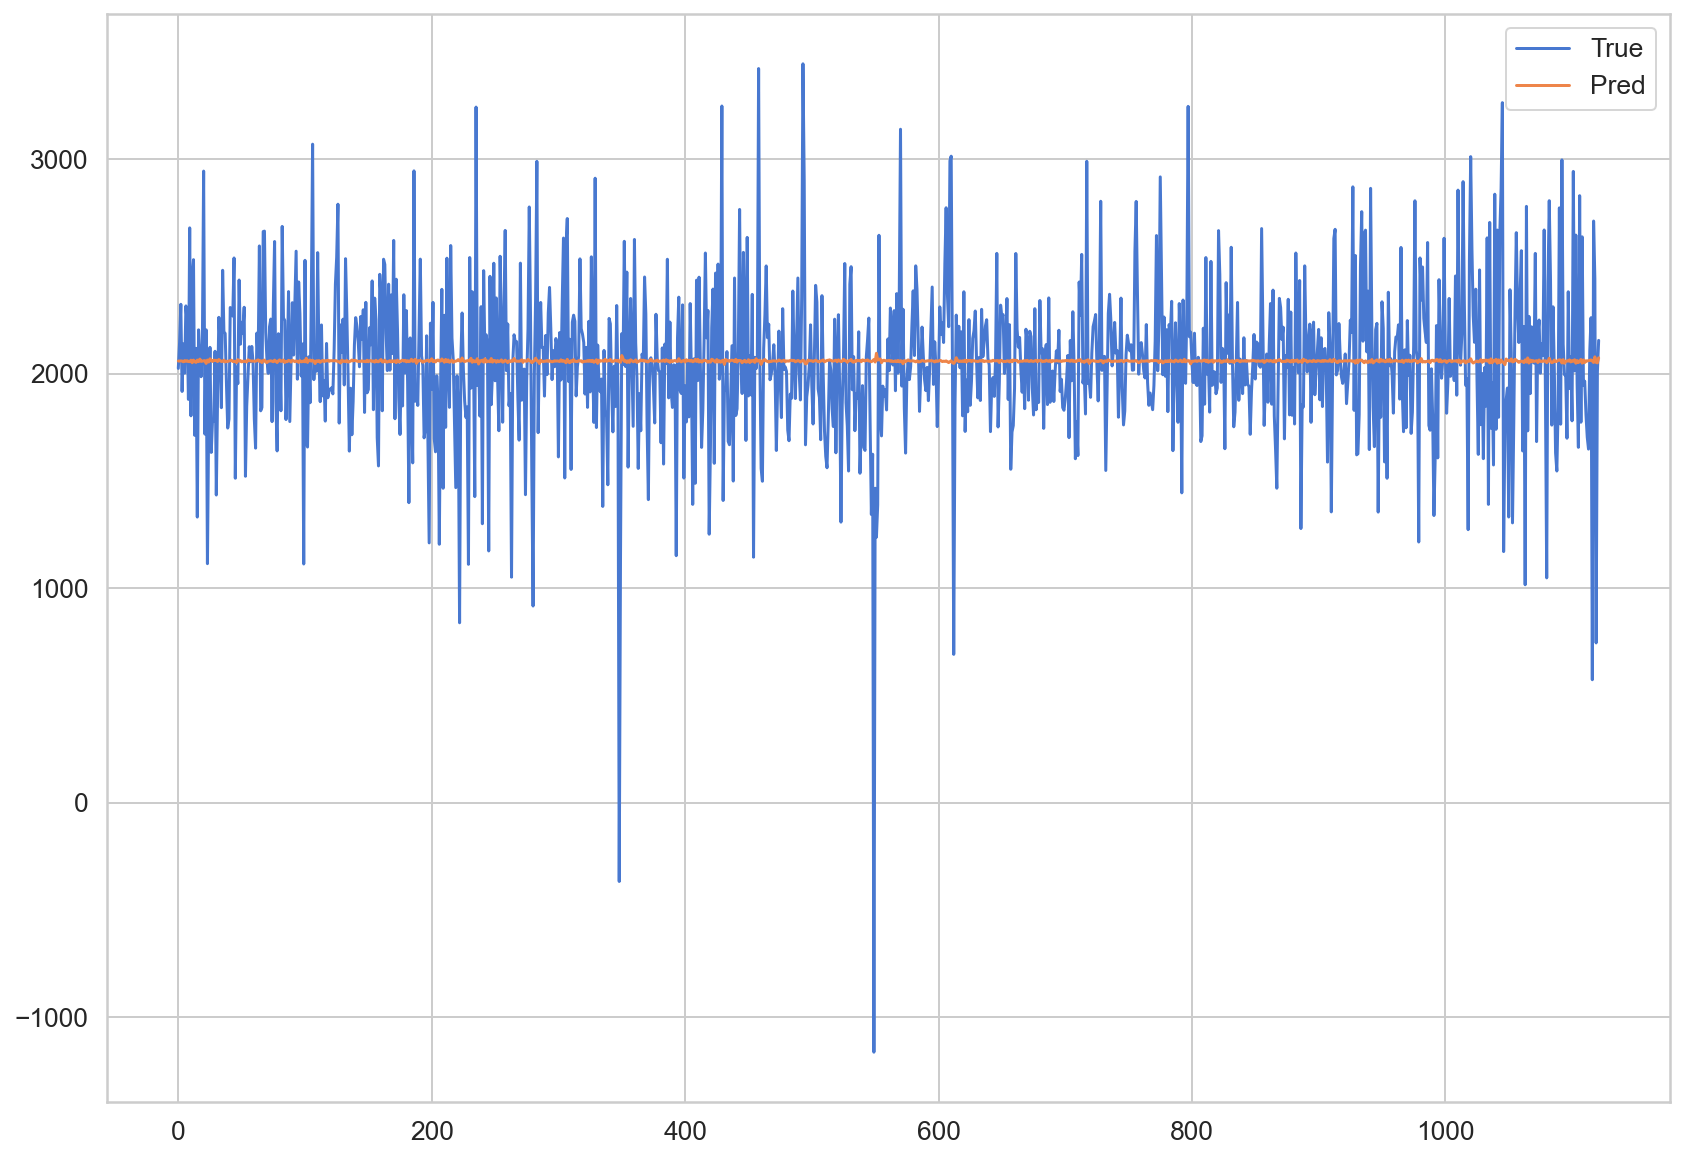

In [33]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [34]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [35]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

257.9380525388098